# Craigslist Capstone Project - Data Wrangling

#### The goal of this capstone is to predict market rent prices in the San Francisco Bay Area. The metros of interest are San Francisco, Peninsula, East Bay. 

Prior to this notebook, the html from craigslist.com rental listings is parsed and saved as a csv file
    * Listing price is the variable we want to predict
    * Listing features include number of bedrooms, bathrooms, address, neighborhood, and optional features provided in `listing_info` and `listing_body` such as whether cats and dogs are allowed, if the rental unit is offered furnished. 
    * Each listing has a unique Listing ID which is set as the index of the dataframe.
    * The listing pages are scraped every 4 days, which means there will be duplicate listings that are exactly the same, and duplicates that are posted over time but are for the same rental unit.


#### This notebook covers the scope of cleaning, transforming and visualizing

1. Drop rows with missing price data and remove duplicate listings
2. Convert data types into appropriate ones for machine learning
3. Clean listing_bathrooms column
4. Clean listing_bedrooms column
5. Filter the listing_sqft column using a chosen min/max
6. Extract listing_info keywords
7. Filter the listing_city column based on how often it occurs
8. Check the metro, neighborhood and listing_city is consistent
9. Handle missing values
10. Extract listing_title keywords
11. Extract listing_body into keywords
12. Summarize the data visually


## Importing the libraries

In [586]:
#Run the following once to install libraries needed for Matplotlib to work
#!conda install nomkl numpy scipy scikit-learn numexpr -y
#!conda remove mkl mkl-service -y

In [587]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import requests
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [588]:
# Neighborhoods in SF
SFC_NEIGHBORHOODS = ['alamo square / nopa', 'bayview', 'bernal heights', 'castro / upper market', 'cole valley / ashbury hts', 'downtown / civic / van ness',
 'excelsior / outer mission', 'financial district', 'glen park', 'haight ashbury', 'hayes valley', 'ingleside / SFSU / CCSF', 'inner richmond',
 'inner sunset / UCSF', 'laurel hts / presidio', 'lower haight', 'lower nob hill', 'lower pac hts', 'marina / cow hollow', 'mission district',
 'nob hill', 'noe valley', 'north beach / telegraph hill', 'pacific heights', 'portola district', 'potrero hill', 'richmond / seacliff', 'russian hill', 
'SOMA / south beach', 'sunset / parkside', 'tenderloin','treasure island', 'twin peaks / diamond hts', 'USF / panhandle', 'visitacion valley', 
'west portal / forest hill', 'western addition']

# Neighborhoods in Peninsula
PEN_NEIGHBORHOODS = ['atherton','belmont','brisbane','burlingame','coastside/pescadero','daly city','east palo alto','foster city','half moon bay','los altos','menlo park','millbrae',
                     'mountain view','pacifica','palo alto','portola valley','redwood city','redwood shores','san bruno','san carlos','san mateo','south san francisco','woodside']

# Neighborhoods in the East Bay
EBY_NEIGHBORHOODS = ['alameda','albany / el cerrito','berkeley','berkeley north / hills','brentwood / oakley','concord / pleasant hill / martinez','danville / san ramon',
                     'dublin / pleasanton / livermore','emeryville','fairfield / vacaville','fremont / union city / newark','hayward / castro valley','hercules, pinole, san pablo, el sob',
                     'lafayette / orinda / moraga','oakland downtown','oakland east','oakland hills / mills','oakland lake merritt / grand','oakland north / temescal',
                     'oakland piedmont / montclair','oakland rockridge / claremont','oakland west','pittsburg / antioch','richmond / point / annex','san leandro','vallejo / benicia','walnut creek']
# List of cities
SFC_CITIES = ['San Francisco']
PEN_CITIES = ['Palo Alto','San Mateo','Mountain View','Redwood City','Menlo Park','Daly City','San Bruno','South San Francisco','Foster City','Burlingame']
EBY_CITIES = ['Oakland','Berkeley','Fremont','Walnut Creek','Concord','Hayward','Alameda','Pleasanton','San Leandro','Vallejo','San Ramon','Emeryville',
        'Dublin','Richmond','Fairfield','Livermore','Antioch','Pittsburg','Union City','El Cerrito']

ALL_CITIES = SFC_CITIES + PEN_CITIES + EBY_CITIES

# Dictionaries for neighborhood and city relationship
METRO_TO_NEIGHBORHOODS = {'sfc': SFC_NEIGHBORHOODS, 'pen': PEN_NEIGHBORHOODS, 'eby': EBY_NEIGHBORHOODS}
METRO_TO_CITIES = {'sfc': SFC_CITIES, 'pen': PEN_CITIES, 'eby': EBY_CITIES}

NEIGHBORHOOD_TO_METRO = {neighborhood: metro for metro, neighborhoods in METRO_TO_NEIGHBORHOODS.items() for neighborhood in neighborhoods}
CITY_TO_METRO = {city: metro for metro,cities in METRO_TO_CITIES.items() for city in cities}

# Create a dictionary mapping listing_info values to the categorical column name
LISTING_INFO_TO_COLUMN = {'cats are OK - purrr':'animals_cats','dogs are OK - wooof':'animals_dogs','furnished':'furnished',
                    'no smoking':'smoking','wheelchair accessible':'wheelchair accessible','air conditioning':'has_AC',
                     'EV charging':'hasEVCharging','laundry in bldg':'laundry_in_bldg','w/d in unit':'laundry_in_unit',
                     'w/d hookups':'laundry_has_hookup','laundry on site':'laundry_onsite','no laundry on site':'laundry_not_onsite',
                     'carport':'parking_carport','attached garage':'parking_attached_garage','detached garage':'parking_detached_garage',
                     'off-street parking':'parking_offstreet','street parking':'parking_street','valet parking':'parking_valet','no parking':'parking_none',
                     'rent period: daily':'rent_period_daily','rent period: weekly':'rent_period_weekly','rent period: monthly':'rent_period_monthly',
                     'condo':'housing_condo','apartment':'housing_apt','cottage/cabin':'housing_cottage','duplex':'housing_duplex',
                     'flat':'housing_flat','house':'housing_house','in-law':'housing_inlaw','loft':'housing_inlaw','townhouse':'housing_townhouse'}

# Create a dictionary mapping listing_body features to the categorical column name
LISTING_BODY_TO_COLUMN = {'rent control':'is_rent_controlled','no pets':'pets_allowed','remodelled':'is_remodelled',
                         '(amenities)|(pool)|(gym)|(spa)':'has_amenities'}

In [589]:
# Check the metro and neighborhood is consistent
def correct_metro(neighborhood, city):
    if city in CITY_TO_METRO:
        return NEIGHBORHOOD_TO_METRO[neighborhood] == CITY_TO_METRO[city]
    else:
        return False
    
def clean_city(city):
    city = city.strip()
    city = city.strip('.')
    if ',' in city:
        return city.split(',')[0]
    if '/' in city:
        return city.split('/')[0]
    return city

# Extract key features from listing_info
def get_listing_info_feature(listing_info_split, target_info):
    for info in listing_info_split:
        if info == target_info:
            return 1
    return 0

# Extract key features from listing_body
def parse_listing_body(text,target_word):
    for key in LISTING_BODY_TO_COLUMN.keys():
        if re.search(target_word, text.lower()) is not None:
            return 1
    return 0

# Extract key features from listing_title
def parse_listing_title_sqft(text):
    pattern = '(\d+)\s?ft2'
    if re.search(pattern, text.lower()) is not None:
        return int(re.search(pattern, text.lower()).group(1))
    return

In [590]:
test = '$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spacious 2-bedroom Home in Grea'


## Load the data

In [591]:
# The parsed html listing data is the interim directory
dir_folder = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/'
listing_df = pd.read_csv(dir_folder + 'listing_df.csv',index_col='listing_id')

# Select the first 10000 rows
# listing_df = listing_df.iloc[:10000,:]

In [592]:
listing_df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,listing_body,listing_url,listing_first_image
listing_id,,,,,,,,,,,,,
7518473082,Charming Update Duplex w/Large Yard,burlingame,Burlingame,2022-08-07T10:39:29-0700,2750,1,1,NaN,Oak Grove near Acacia,cats are OK - purrr dogs are OK - wooof dup...,"Large front and back yard, along a quaint neig...",https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00k0k_9yaPmYku1l...
7522326058,"Spacious Studio * Minutes to Dining, Shopping!",burlingame,Burlingame,2022-08-16T17:17:40-0700,2500,0,1,NaN,1401 Floribunda Ave,apartment laundry in bldg no smoking attac...,Welcome Home to Classic Peninsula Living at Th...,https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00D0D_aFhw5Xkeqe...
7510413512,Where City Living Reaches New Heights Come to ...,daly city,San Francisco,2022-07-18T13:00:26-0700,3450,2,2,1130.0,NaN,application fee details: $39 cats are OK - p...,Highpoint Terrace San Francisco www.highpoints...,https://sfbay.craigslist.org/pen/apa/d/san-fra...,https://images.craigslist.org/00P0P_pHGfLJMzGf...
7526323338,"Wi-Fi in Community Areas, Spacious Open-Concep...",burlingame,Burlingame,2022-08-26T12:02:23-0700,3466,1,1,793.0,1008 Carolan Ave,EV charging cats are OK - purrr dogs are OK...,"Burlingame Spirit, Anson Prestige Brand-New Ap...",https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00o0o_bypIwAvRZc...
7503964545,BEAUTIFUL BURLINGAME HOME FOR LEASE!,burlingame,Burlingame,2022-07-02T10:31:55-0700,6500,3,2,1960.0,1711 Marco Polo Way near Clarice,house w/d in unit no smoking attached gara...,"Beautifully remodeled 3 bedroom, 2 bath + sepa...",https://sfbay.craigslist.org/pen/apa/d/burling...,https://images.craigslist.org/00y0y_5q38PKEa4B...


In [593]:
listing_df.describe()

,listing_price,listing_bedrooms,listing_sqft
count,1.732720e+05,173272.000000,143978.000000
mean,4.789263e+03,1.551145,899.431316
std,2.463113e+05,0.917255,1097.390054
min,1.000000e+00,0.000000,1.000000
25%,2.350000e+03,1.000000,656.000000
50%,2.893000e+03,1.000000,801.000000
75%,3.692000e+03,2.000000,1011.000000
max,3.875318e+07,8.000000,94103.000000


In [594]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173272 entries, 7518473082 to 7514097657
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   listing_title        173272 non-null  object 
 1   listing_nh           173272 non-null  object 
 2   listing_city         173272 non-null  object 
 3   listing_date         173272 non-null  object 
 4   listing_price        173272 non-null  int64  
 5   listing_bedrooms     173272 non-null  int64  
 6   listing_bathrooms    173272 non-null  object 
 7   listing_sqft         143978 non-null  float64
 8   listing_address      158979 non-null  object 
 9   listing_info         173272 non-null  object 
 10  listing_body         173272 non-null  object 
 11  listing_url          173272 non-null  object 
 12  listing_first_image  173272 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 18.5+ MB


In [595]:
listing_dr_rows = listing_df.shape[0]
listing_df.shape

(173272, 13)

In [596]:
listing_df.describe()

,listing_price,listing_bedrooms,listing_sqft
count,1.732720e+05,173272.000000,143978.000000
mean,4.789263e+03,1.551145,899.431316
std,2.463113e+05,0.917255,1097.390054
min,1.000000e+00,0.000000,1.000000
25%,2.350000e+03,1.000000,656.000000
50%,2.893000e+03,1.000000,801.000000
75%,3.692000e+03,2.000000,1011.000000
max,3.875318e+07,8.000000,94103.000000


## 1. Drop rows with missing price data and remove duplicate listings
Drop duplicates using 3 filters: (Note: optional fields in craigslist are address, neighborhood)
* Filter 1: by title, bedroom, bathroom, neighborhood
* Filter 2: by image link, bedroom, bathroom, neighborhood
* Filter 3: by listing_address, listing_city, bedroom, bathroom

In [597]:
# Drop rows that are missing price data
#listing_df = listing_df.dropna(subset=['listing_price'])

# Drop rows where price is below a chosen min and max
price_min = 500
price_max = 20000
listing_df = listing_df.loc[(listing_df.listing_price > price_min) & (listing_df.listing_price < price_max)]

In [598]:
# Look at the number of exact duplicates
duplicates = listing_df['listing_title'].value_counts()
duplicates.head()

First-floor two-bedroom in Theater District                      752
Amazing 2 bed 2 bath home                                        412
***UP to 8-weeks OFF RENT!!*** Apply Today!                      358
Gorgeous 1Bd,1Ba in Newly Renovated Community Downtown Living    210
Renovated 1x1 Apartment with In-Wall USB Charging Ports          191
Name: listing_title, dtype: int64

In [599]:
print('Total number of duplicates by listing title: {}'.format(duplicates[duplicates != 1].sum()))

Total number of duplicates by listing title: 167266


In [600]:
# 1. Drop duplicates by subset of title, bedroom, bathroom, neighborhood
df_drop_by_filter1 = listing_df.drop_duplicates(subset = ['listing_title','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 1: {df_drop_by_filter1.shape[0]} rows, {df_drop_by_filter1.shape[1]} columns")
print(f"Filter 1 dropped {listing_dr_rows - df_drop_by_filter1.shape[0]} rows")

Dataframe size after filter 1: 33355 rows, 13 columns
Filter 1 dropped 139917 rows


In [601]:
# 2. Drop duplicates by subset of image link, bedroom, bathroom, neighborhood
df_drop_by_filter2 = df_drop_by_filter1.drop_duplicates(subset = ['listing_first_image','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 2: {df_drop_by_filter2.shape[0]} rows, {df_drop_by_filter2.shape[1]} columns")
print(f"Filter 2 dropped {df_drop_by_filter1.shape[0] - df_drop_by_filter2.shape[0]} rows")

Dataframe size after filter 2: 23690 rows, 13 columns
Filter 2 dropped 9665 rows


In [602]:
# 3. Drop duplicates by subset of listing_address, listing_city, bedroom, bathroom
df_drop_by_filter3 = df_drop_by_filter2.drop_duplicates(subset = ['listing_address','listing_city','listing_bedrooms','listing_bathrooms'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 3: {df_drop_by_filter3.shape[0]} rows, {df_drop_by_filter3.shape[1]} columns")
print(f"Filter 3 dropped {df_drop_by_filter2.shape[0] - df_drop_by_filter3.shape[0]} rows")

Dataframe size after filter 3: 11093 rows, 13 columns
Filter 3 dropped 12597 rows


In [603]:
# Compare with dropping duplicates based on all columns
df_drop_by_all_cols = listing_df.drop_duplicates(keep = 'last', inplace = False)
df_drop_by_all_cols.shape
print(f"Dataframe size after dropping based on all columns: {df_drop_by_all_cols.shape[0]} rows, {df_drop_by_all_cols.shape[1]} columns")
print(f"Dropping duplicates by all columns dropped {listing_dr_rows - df_drop_by_all_cols.shape[0]} rows")

Dataframe size after dropping based on all columns: 51665 rows, 13 columns
Dropping duplicates by all columns dropped 121607 rows


In [604]:
# Use all 3 filters
df = df_drop_by_filter3
df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,listing_body,listing_url,listing_first_image
listing_id,,,,,,,,,,,,,
7520103440,Beautiful and Spacious NEW remodeled Silicon V...,fremont / union city / newark,Fremont,2022-08-11T09:51:58-0700,3800,3,2,1495.0,Newport Dr,open house dates saturday 2022-08-13 sun...,Great location 3 Bed 2 Bath Single Family Hous...,https://sfbay.craigslist.org/eby/apa/d/fremont...,https://images.craigslist.org/00C0C_iEcKsVmzdg...
7520292010,"Spacious, bright live/work loft with all utili...",oakland west,Oakland,2022-08-11T16:49:29-0700,2450,1,1,925.0,1468 32nd St near louise,application fee details: $45 cats are OK - p...,"Spacious, bright live/work loft with all utili...",https://sfbay.craigslist.org/eby/apa/d/emeryvi...,https://images.craigslist.org/00n0n_9bLXcwFIi1...
7520905091,Highly desired Vista neighborhood with a charm...,vallejo / benicia,Vallejo,2022-08-13T09:04:22-0700,2100,2,1,904.0,226 Edgemont Avenue near Edgemont Avenue,EV charging air conditioning cats are OK - ...,Highly desired Vista neighborhood with a charm...,https://sfbay.craigslist.org/eby/apa/d/vallejo...,https://images.craigslist.org/00c0c_8OXB1Zm4PN...
7520907681,lovely 2-bedroom 2 bath home with open floor p...,vallejo / benicia,Vallejo,2022-08-13T09:09:26-0700,2200,2,2,1420.0,1509 Sacramento Street near Sacramento Street,EV charging air conditioning cats are OK - ...,lovely 2-bedroom 2 bath home with open floor p...,https://sfbay.craigslist.org/eby/apa/d/vallejo...,https://images.craigslist.org/00303_28XoaVJ8dA...
7520608095,"$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spaciou...",dublin / pleasanton / livermore,Pleasanton,2022-08-12T12:34:49-0700,3935,2,2,NaN,1552 E Gate Way,air conditioning application fee details: $5...,Available Date: Now Apartment #: 110 Size: 1...,https://sfbay.craigslist.org/eby/apa/d/pleasan...,https://images.craigslist.org/00g0g_ikx5DdQu5V...


## 2. Convert data types

In [605]:
df.dtypes

listing_title           object
listing_nh              object
listing_city            object
listing_date            object
listing_price            int64
listing_bedrooms         int64
listing_bathrooms       object
listing_sqft           float64
listing_address         object
listing_info            object
listing_body            object
listing_url             object
listing_first_image     object
dtype: object

In [606]:
df.is_copy = False
# Convert the listing_date column into datetime
df['listing_date'] = pd.to_datetime(df['listing_date'])

## 3. Clean listing_bathrooms column
The bathroom category can stay as a categorical feature

In [607]:
# Trim trailing spaces on string values in listing_bathrooms
df['listing_bathrooms'] = df['listing_bathrooms'].map(lambda x: x.strip())
df['listing_bathrooms'].unique()

array(['2', '1', '2.5', '3', '3.5', '1.5', 'shared', 'split', '4', '5',
       '4.5', '6', '6.5', '9+', '8', '5.5'], dtype=object)

In [608]:
df['listing_bathrooms'].value_counts()

1         6903
2         2499
1.5        514
2.5        479
3          377
3.5         99
shared      77
split       69
4           48
4.5         16
5            7
6            1
6.5          1
9+           1
8            1
5.5          1
Name: listing_bathrooms, dtype: int64

In [609]:
# 1 split bathroom is the same as 1 bathroom, so convert 'split' to type '1'
df['listing_bathrooms'][df['listing_bathrooms'] == 'split'] = '1'

# Since these are the only inputs for bathroom in the craigslist UI, lump all bathrooms > 3 into a single type '3+'
extra_bath = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5','9+']
df['listing_bathrooms'][df['listing_bathrooms'].isin(extra_bath)] = '4+'

In [610]:
df['listing_bathrooms'].value_counts()

1         6972
2         2499
1.5        514
2.5        479
3          377
3.5         99
shared      77
4+          76
Name: listing_bathrooms, dtype: int64

Text(0.5, 1.0, 'Distribution of bathrooms across craigslist listings')

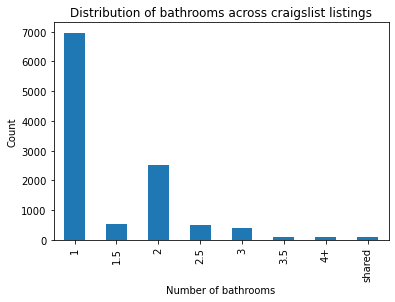

In [611]:
df['listing_bathrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')
plt.title('Distribution of bathrooms across craigslist listings')

## 4. Clean listing_bedrooms column
Consolidate data into categories that belong together e.g. lump 6,7,8 bedroom places into 6+ bedrooms.

The bedroom category can also stay as a categorical feature

In [612]:
# Lump all bedrooms >= 6 into a single type '6+'
extra_bed = ['6', '7', '8']
df['listing_bedrooms'] = df['listing_bedrooms'].astype('str')
df['listing_bedrooms'][df['listing_bedrooms'].isin(extra_bed)] = '6+'
df['listing_bedrooms'].value_counts()

2     3732
1     3641
3     1744
0     1109
4      678
5      146
6+      43
Name: listing_bedrooms, dtype: int64

Text(0.5, 1.0, 'Distribution of bedrooms across craigslist listings')

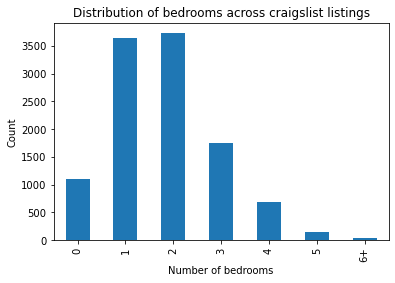

In [613]:
# Look at distributions of number of bedroom data
df['listing_bedrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bedrooms')
plt.ylabel('Count')
plt.title('Distribution of bedrooms across craigslist listings')

In [614]:
df.shape

(11093, 13)

## 5. Filter the listing_sqft column using a chosen min/max
This will eliminate obvious outliers and wrong inputs

In [615]:
df['listing_sqft'].describe()

count     7596.000000
mean      1070.261717
std       1624.055877
min          1.000000
25%        680.000000
50%        900.000000
75%       1250.000000
max      94103.000000
Name: listing_sqft, dtype: float64

In [616]:
df_rows_before_sqft = df.shape[0]
# If there is a sqft value, drop sqft values that are too small or too big (the 94103 is clearly a zip code)
sqft_min = 200
sqft_max = 30000

df_sqft_transformed = df.listing_sqft.replace('',np.nan)
print(f'The listing_sqft column is missing {df_sqft_transformed.isnull().sum()} rows of data')

df_transformed = df
df_transformed['listing_sqft'] = df_sqft_transformed
df_transformed = df_transformed.loc[(df_transformed.listing_sqft.isnull()) | ((df_transformed.listing_sqft > sqft_min) & (df_transformed.listing_sqft < sqft_max))]
df_rows_after_sqft = df_transformed.shape[0]
print(f'Dropped {df_rows_after_sqft-df_rows_before_sqft} rows that were outside the bounds of the min and max')

The listing_sqft column is missing 3497 rows of data
Dropped -67 rows that were outside the bounds of the min and max


In [617]:
df_transformed['listing_sqft'].describe()

count     7529.000000
mean      1053.716430
std        595.387263
min        208.000000
25%        686.000000
50%        900.000000
75%       1250.000000
max      13000.000000
Name: listing_sqft, dtype: float64

## 6. Extract listing_info keywords
Since these keywords are optional inputs in Craigslist.com, the string varies in length. 
Convert from a string into a list of values that will be converted to their own columns. 

In [618]:
# Convert listing_info from string of values to a list of values
df_transformed['listing_info_split'] = df_transformed['listing_info'].apply(lambda x: x.strip().split("  "))

In [619]:
for target_info, column in LISTING_INFO_TO_COLUMN.items():
    df_transformed[column] = df_transformed['listing_info_split'].apply(lambda x: get_listing_info_feature(x, target_info))

In [620]:
df_transformed.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,rent_period_weekly,rent_period_monthly,housing_condo,housing_apt,housing_cottage,housing_duplex,housing_flat,housing_house,housing_inlaw,housing_townhouse
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,Beautiful and Spacious NEW remodeled Silicon V...,fremont / union city / newark,Fremont,2022-08-11 09:51:58-07:00,3800,3,2,1495.0,Newport Dr,open house dates saturday 2022-08-13 sun...,...,0,0,0,0,0,0,0,0,0,0
7520292010,"Spacious, bright live/work loft with all utili...",oakland west,Oakland,2022-08-11 16:49:29-07:00,2450,1,1,925.0,1468 32nd St near louise,application fee details: $45 cats are OK - p...,...,0,1,0,0,0,0,0,0,1,0
7520905091,Highly desired Vista neighborhood with a charm...,vallejo / benicia,Vallejo,2022-08-13 09:04:22-07:00,2100,2,1,904.0,226 Edgemont Avenue near Edgemont Avenue,EV charging air conditioning cats are OK - ...,...,0,1,0,0,0,0,0,1,0,0
7520907681,lovely 2-bedroom 2 bath home with open floor p...,vallejo / benicia,Vallejo,2022-08-13 09:09:26-07:00,2200,2,2,1420.0,1509 Sacramento Street near Sacramento Street,EV charging air conditioning cats are OK - ...,...,0,1,0,0,0,0,0,1,0,0
7520608095,"$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spaciou...",dublin / pleasanton / livermore,Pleasanton,2022-08-12 12:34:49-07:00,3935,2,2,NaN,1552 E Gate Way,air conditioning application fee details: $5...,...,0,1,0,1,0,0,0,0,0,0


## 7. Filter the listing_city column based on how often it occurs
There are some typos in this column because it is a user input.
There are also some cities listed with state and punctuation that should be removed

In [621]:
df_transformed['listing_city'].value_counts()

San Francisco         3610
Oakland               1315
Berkeley               515
San Mateo              224
Fremont                220
                      ... 
North Oakland NOBE       1
Van Buren                1
Oakland, CA 94602        1
Milpitas                 1
Oakland CA               1
Name: listing_city, Length: 403, dtype: int64

In [622]:
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: x.title())
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: clean_city(x))
df_transformed['listing_city'].value_counts()

# Get index of cities that occur less than 5 times (these are typos or errors)
x = df_transformed['listing_city'].value_counts()
city_to_drop = list((x[x < 5]).index)

# Drop city values that are lower than a value count of 2
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: None if x in city_to_drop else x)

In [623]:
df_transformed['listing_city'].value_counts().head()

San Francisco    4016
Oakland          1467
Berkeley          558
San Mateo         249
Fremont           246
Name: listing_city, dtype: int64

## 8. Check the metro, neighborhood and listing_city is consistent
Some listings are posted in the wrong metro, or have incorrect neighborhood tags. Drop these rows 

In [624]:
# If a listing has a neighborhood tag, cross reference it with the listing_city to make sure it is in the correct city, otherwise remove from df
df_transformed['is_consistent_metro'] = df_transformed.apply(lambda x: correct_metro(x['listing_nh'], x['listing_city']), axis=1)
df_correct_metro = df_transformed[df_transformed['is_consistent_metro'] == True]

print(f'After checking for consistent metro, dropped {df_correct_metro.shape[0] - df_transformed.shape[0]} rows')
print(f'Database now has {df_correct_metro.shape[0]} rows')

After checking for consistent metro, dropped -1314 rows
Database now has 9712 rows


In [625]:
# Check there are not too many duplicated addresses
df_dup = df_correct_metro["listing_address"].notnull().duplicated()
duplicate_addresses = df_correct_metro[df_dup].groupby('listing_address').listing_title.count().sort_values(ascending=False)
duplicate_addresses[duplicate_addresses > 3]
# The max number of times an address shows up is only 6, which seems reasonable since some are apartment buildings

listing_address
2016 Telegraph Ave near 20th Street             6
3093 Broadway near Piedmont                     6
3093 BROADWAY OAKLAND CA 94611 near Piedmont    6
312 24th St                                     6
1333 north camino alto                          5
                                               ..
3110 Casa De Campo                              4
3098 Kyne Street W                              4
4510 Hubbard St.                                4
780 Oak Gove Road near Treat Blvd               4
1001 Harvey Drive                               4
Name: listing_title, Length: 93, dtype: int64

## 9. Handle missing values

In [626]:
# Missing values in numeric columns
missing = pd.concat([df_correct_metro.isnull().sum(), 100 * df_correct_metro.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,3202,32.969522
listing_address,314,3.233114
listing_title,0,0.000000
rent_period_weekly,0,0.000000
parking_carport,0,0.000000
parking_attached_garage,0,0.000000
parking_detached_garage,0,0.000000
parking_offstreet,0,0.000000
parking_street,0,0.000000
parking_valet,0,0.000000


## 10. Extract listing_title keywords

In [633]:
# Use Regex to extract sqft and address information from listing_title for nan values
missing_sqft = df_correct_metro[df_correct_metro.listing_sqft.isnull()][['listing_title','listing_sqft']]

title_sqft = missing_sqft['listing_title'].apply(lambda x: parse_listing_title_sqft(x))
title_sqft = title_sqft[title_sqft.notnull()]

# Join the data on index
df = df_correct_metro.merge(title_sqft, left_index=True, right_index=True, how='left')

# Replace nan values in listing_sqft with values from title_sqft
df['listing_sqft'] = df['listing_sqft'].fillna(df['listing_title_y'])

# Delete the extra columns that are not needed
df = df.drop(['listing_title_y','is_consistent_metro'],axis=1)

# Rename listing_title
df.rename(columns = {'listing_title_x':'listing_title'}, inplace = True)

In [634]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,3197,32.918040
listing_address,314,3.233114
listing_title,0,0.000000
rent_period_daily,0,0.000000
laundry_not_onsite,0,0.000000
parking_carport,0,0.000000
parking_attached_garage,0,0.000000
parking_detached_garage,0,0.000000
parking_offstreet,0,0.000000
parking_street,0,0.000000


## 11. Extract listing_body into keywords
The listing_body contains the bulk of the text in a craigslist listing. 
There is a lot of information as text and provides a good summary of the rental unit, but most of the details in the body are already in the feature columns.

Use the dictionary LISTING_BODY_TO_COLUMN to parse the most important details: 
* Is the place rent controlled
* Are pets allowed 
* Has the place been remodelled
* Are there amenities that come with the rental unit e.g. pool, gym, spa


In [635]:
for target_word, column_name in LISTING_BODY_TO_COLUMN.items():
    df[column_name] = df['listing_body'].apply(lambda x: parse_listing_body(x, target_word))

In [636]:
df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,housing_cottage,housing_duplex,housing_flat,housing_house,housing_inlaw,housing_townhouse,is_rent_controlled,pets_allowed,is_remodelled,has_amenities
listing_id,,,,,,,,,,,,,,,,,,,,,
7495842903,"$1695/1br - Spacious, Furnished Studio on Quie...",palo alto,Palo Alto,2022-06-13 01:02:29-07:00,1695,1,1,400.0,Charleston near Alma,apartment w/d in unit street parking rent ...,...,0,0,0,0,0,0,0,1,0,1
7495966009,"LIVE/WORK/ART LOFT NATURAL SUNLIGHT, INDUSTRIA...",mission district,San Francisco,2022-06-13 08:59:09-07:00,4999,1,1,927.0,555 Florida St. near Mariposa,open house dates thursday 2022-07-28 fri...,...,0,0,0,0,0,0,0,1,0,1
7496082921,"$2,125 Studio! Jingle Town! Welcome To 3030 Ch...",oakland east,Oakland,2022-06-13 12:22:44-07:00,2125,0,1,505.0,3030 Chapman Street near derby,cats are OK - purrr dogs are OK - wooof apa...,...,0,0,0,0,0,0,0,0,0,1
7496092147,Nicely Renovated 2bd/1ba W/New Carpet in Bedro...,oakland east,Oakland,2022-06-13 12:40:39-07:00,2350,2,1,NaN,3050 Fruitvale Ave.,application fee details: Credit Report Check ...,...,0,0,0,0,0,0,0,1,0,1
7496134063,ID#573: Pac Hgts 2BR/1BA Flat w/Pkg & Shared Yd,pacific heights,San Francisco,2022-06-13 14:03:39-07:00,4500,2,1,NaN,Fillmore Street near Jackson Street,apartment laundry in bldg no smoking attac...,...,0,0,0,0,0,0,0,0,0,1


## 12. Summarize the data visually

<AxesSubplot:>

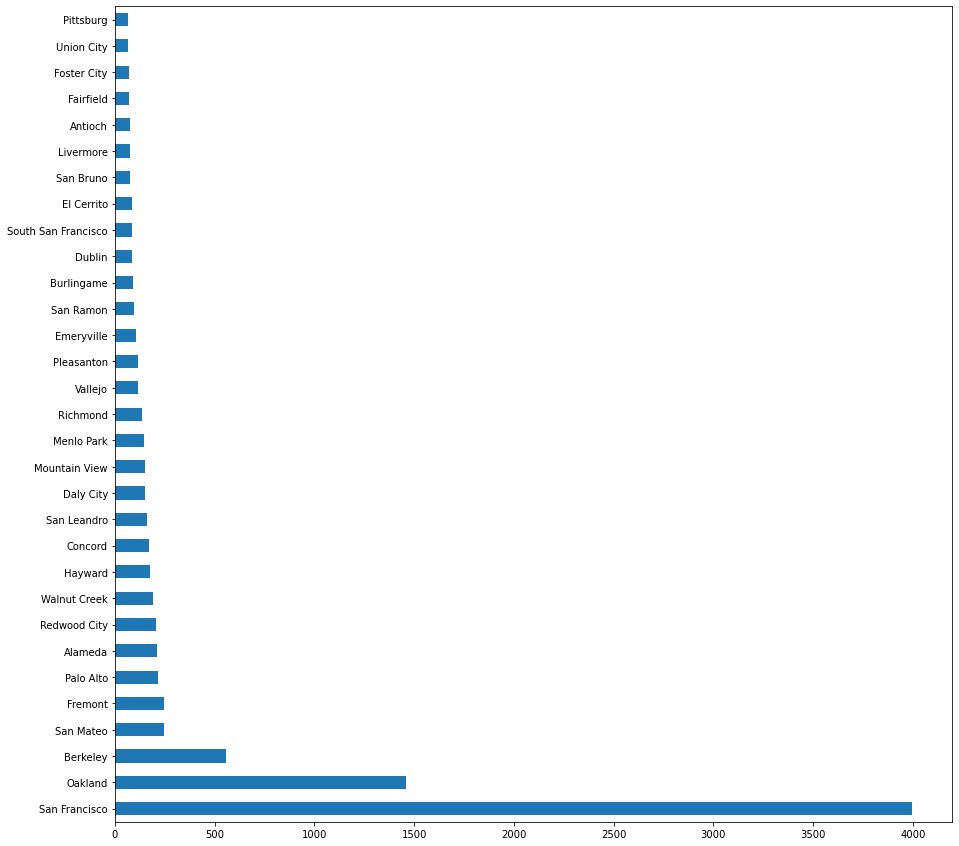

In [637]:
df['listing_city'].value_counts().head(50).plot(kind='barh',figsize=(15,15))

In [638]:
nh_count = df[['listing_nh','listing_city']].value_counts().reset_index()
nh_count.columns = ['neighborhood', 'city', 'count']
nh_metro_df = pd.DataFrame(nh_count)
nh_metro_df['metro'] = nh_metro_df.apply(lambda x: CITY_TO_METRO[x.city], axis=1)
nh_metro_df.head()

,neighborhood,city,count,metro
0,berkeley,Berkeley,481,eby
1,oakland lake merritt / grand,Oakland,442,eby
2,SOMA / south beach,San Francisco,437,sfc
3,mission district,San Francisco,312,sfc
4,nob hill,San Francisco,296,sfc


[Text(0, 0, 'berkeley'),
 Text(1, 0, 'oakland lake merritt / grand'),
 Text(2, 0, 'SOMA / south beach'),
 Text(3, 0, 'mission district'),
 Text(4, 0, 'nob hill'),
 Text(5, 0, 'fremont / union city / newark'),
 Text(6, 0, 'san mateo'),
 Text(7, 0, 'oakland downtown'),
 Text(8, 0, 'oakland east'),
 Text(9, 0, 'alameda'),
 Text(10, 0, 'palo alto'),
 Text(11, 0, 'redwood city'),
 Text(12, 0, 'sunset / parkside'),
 Text(13, 0, 'walnut creek'),
 Text(14, 0, 'marina / cow hollow'),
 Text(15, 0, 'pacific heights'),
 Text(16, 0, 'richmond / seacliff'),
 Text(17, 0, 'concord / pleasant hill / martinez'),
 Text(18, 0, 'hayward / castro valley'),
 Text(19, 0, 'oakland north / temescal')]

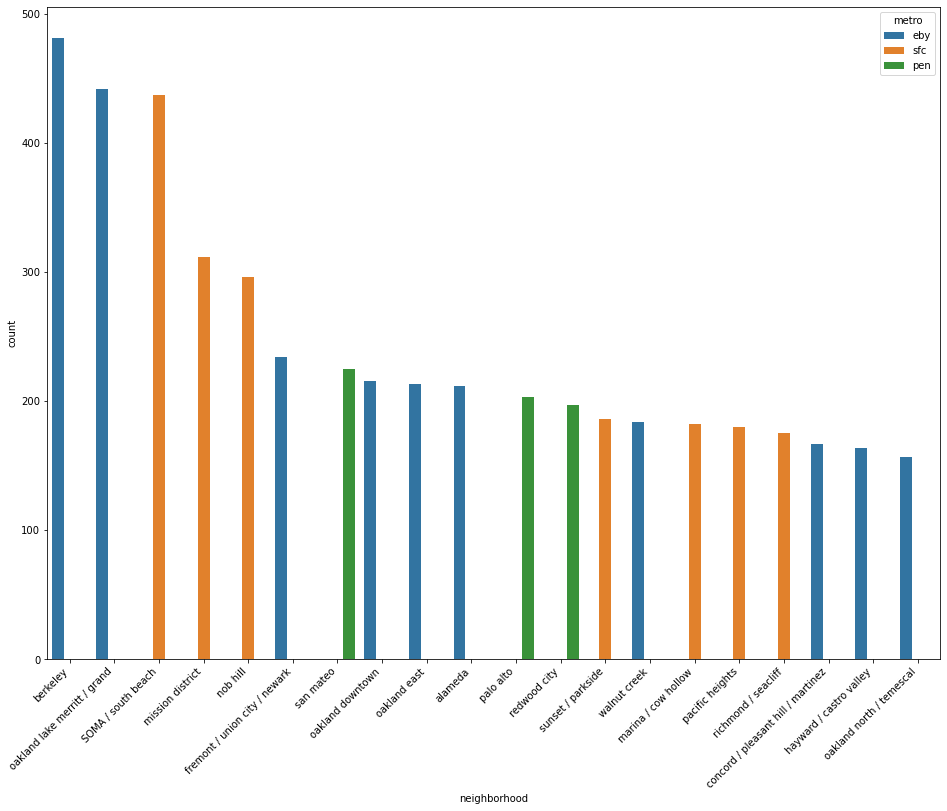

In [639]:
plt.subplots(figsize=(16, 12))
ax = sns.barplot(x=nh_metro_df['neighborhood'][:20],y=nh_metro_df['count'][:20],hue=nh_metro_df['metro'][:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

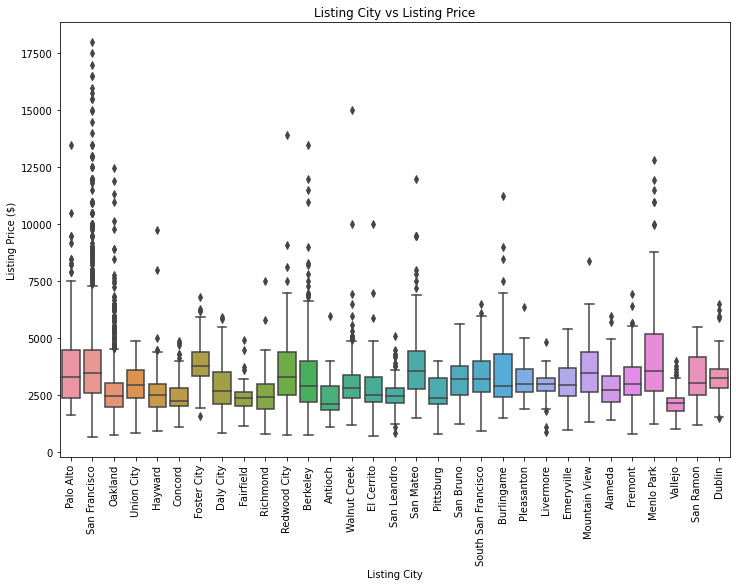

In [640]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='listing_city', y='listing_price', data=df)
plt.xticks(rotation='vertical')
plt.ylabel('Listing Price ($)')
plt.xlabel('Listing City')
plt.title('Listing City vs Listing Price');

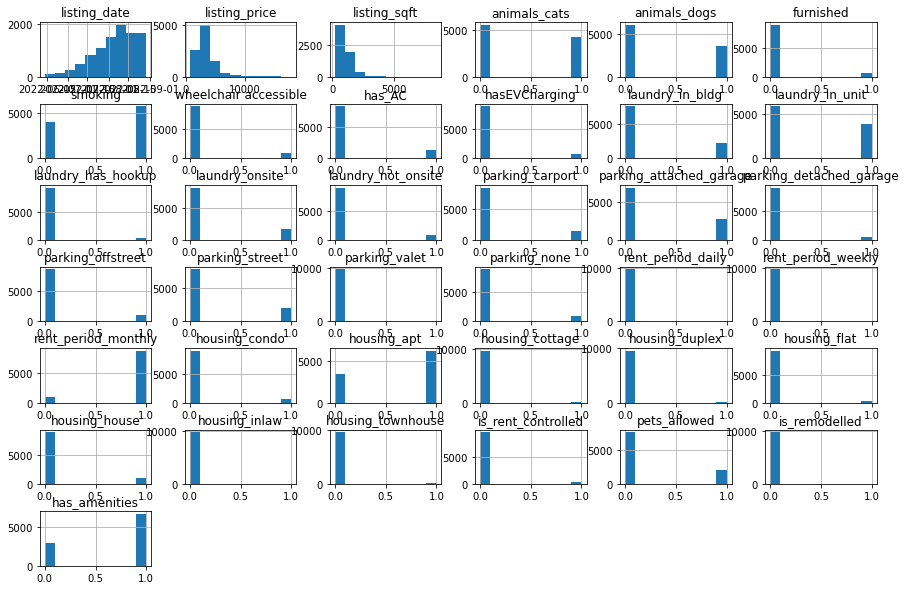

In [641]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [642]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9712 entries, 7495842903 to 7527210592
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype                                 
---  ------                   --------------  -----                                 
 0   listing_title            9712 non-null   object                                
 1   listing_nh               9712 non-null   object                                
 2   listing_city             9712 non-null   object                                
 3   listing_date             9712 non-null   datetime64[ns, pytz.FixedOffset(-420)]
 4   listing_price            9712 non-null   int64                                 
 5   listing_bedrooms         9712 non-null   object                                
 6   listing_bathrooms        9712 non-null   object                                
 7   listing_sqft             6515 non-null   float64                               
 8   listing_address        

In [643]:
df.to_csv(r'/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_cleaned.csv', header=True)
print('Saved to csv file')

Saved to csv file


In [644]:
df.shape

(9712, 48)